In [8]:
from pathlib import Path
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.transform import radon
from skimage.feature import graycomatrix, graycoprops

import tqdm

In [9]:
# Configuration
img_root = Path("../../clothing-pattern-dataset") # Data from https://github.com/lstearns86/clothing-pattern-dataset?tab=readme-ov-file
feature_path = Path("features.csv")

IMG_SIZE = (224, 224)
GAUSSIAN_BLUR_KSIZE = (3, 3)
CANNY_THRESHOLDS = (50, 150)

RADON_THETAS = np.arange(0, 180, 1)  # degrees 0..179
RADON_FEATURE_LENGTH = 200           # resample to 200 dims (paper parity)

GLCM_LEVELS = 8
GLCM_DISTANCES = [1]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

COLOR_BINS = ["white", "black", "gray", "red",
              "yellow", "green", "cyan", "blue", "magenta"]

In [10]:
# Image discovery

def discover_images(root: Path):
    """Yield (class_name, image_path) for files under root/<class>/*"""
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
    # subfolders are class names
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        cls_name = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                yield cls_name, p


images = list(discover_images(img_root))

In [11]:
# Feature extraction Functions

def blur_features(img_rgb: np.ndarray) -> dict:
    bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    bgr = cv2.GaussianBlur(bgr, GAUSSIAN_BLUR_KSIZE, 0)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def color_quantization_hsv(img_rgb: np.ndarray) -> dict:
    """
    Approximate HSI logic using HSV (OpenCV). Return % pixels in:
    white, black, gray + 6 hues (R,Y,G,C,B,M).
    """
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H = hsv[..., 0].astype(np.float32)          # 0..179
    S = hsv[..., 1].astype(np.float32) / 255.0  # 0..1
    V = hsv[..., 2].astype(np.float32) / 255.0  # 0..1

    total = H.size
    eps = 1e-9

    black = (V <= 0.20)
    white = (V >= 0.90) & (S <= 0.10)
    gray = (S <= 0.20) & (~black) & (~white)

    color_mask = ~(black | white | gray)
    Hdeg = H * 2.0  # 0..358

    def hrange(h, lo, hi):
        # circular
        if lo <= hi:
            return (h >= lo) & (h < hi)
        else:
            return (h >= lo) | (h < hi)

    red = color_mask & (hrange(Hdeg, 345, 360) | hrange(Hdeg, 0, 15))
    yellow = color_mask & hrange(Hdeg, 15, 45)
    green = color_mask & hrange(Hdeg, 45, 75)
    cyan = color_mask & hrange(Hdeg, 75, 165)
    blue = color_mask & hrange(Hdeg, 165, 255)
    magenta = color_mask & hrange(Hdeg, 255, 345)

    counts = {
        "white": int(np.count_nonzero(white)),
        "black": int(np.count_nonzero(black)),
        "gray":  int(np.count_nonzero(gray)),
        "red":   int(np.count_nonzero(red)),
        "yellow": int(np.count_nonzero(yellow)),
        "green": int(np.count_nonzero(green)),
        "cyan":  int(np.count_nonzero(cyan)),
        "blue":  int(np.count_nonzero(blue)),
        "magenta": int(np.count_nonzero(magenta)),
    }
    return {k: (v / (total + eps)) * 100.0 for k, v in counts.items()}

# -------------- Radon signature (rotation-invariant) --------------


def radon_signature(img_rgb: np.ndarray) -> np.ndarray:
    """
    1) Canny edges on grayscale
    2) Radon transform over angles 0..179
    3) Sum across rho -> 1D signature over theta
    4) Circularly shift to center the dominant peak (rotation invariance)
    5) Resample to 200 dims and L1-normalize
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, CANNY_THRESHOLDS[0], CANNY_THRESHOLDS[1]).astype(
        np.float32) / 255.0
    sino = radon(edges, theta=RADON_THETAS,
                 circle=False)               # [rho, theta]
    sig = np.sum(np.abs(sino), axis=0).astype(
        np.float32)                # [theta]

    # center dominant direction
    max_idx = int(np.argmax(sig))
    shift = len(sig)//2 - max_idx
    sig = np.roll(sig, shift)

    # resample to 200
    x_old = np.linspace(0, 1, num=len(sig), endpoint=False)
    x_new = np.linspace(0, 1, num=RADON_FEATURE_LENGTH, endpoint=False)
    sig = np.interp(x_new, x_old, sig).astype(np.float32)

    sig /= (sig.sum() + 1e-9)  # L1
    return sig  # shape (200,)

# -------------- GLCM features (8×8) --------------


def glcm_features(img_rgb: np.ndarray) -> dict:
    """
    Quantize grayscale to 8 levels, compute GLCM for 4 angles,
    return mean contrast, homogeneity, energy, correlation.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    q = (gray // (256 // GLCM_LEVELS)).astype(np.uint8)  # 0..7
    glcm = graycomatrix(q, distances=GLCM_DISTANCES, angles=GLCM_ANGLES,
                        levels=GLCM_LEVELS, symmetric=True, normed=True)
    feats = {}
    for prop in ["contrast", "homogeneity", "energy", "correlation"]:
        vals = graycoprops(glcm, prop)  # shape (len(distances), len(angles))
        feats[prop] = float(np.mean(vals))
    return feats

In [12]:
# Extract features
def extract_and_save_features():
    rows = []

    for cls_name, p in tqdm.tqdm(images):
        try:
            img = Image.open(p).convert("RGB")
            img = np.array(img.resize(IMG_SIZE, resample=Image.BILINEAR))

            img = blur_features(img)

        except Exception as e:
            print(f"[WARN] skipping {p}: {e}")
            continue
        
        color = color_quantization_hsv(img)
        radon_sig = radon_signature(img) 
        glcm = glcm_features(img)

        row = {
            "class": cls_name,
            "file": str(p.relative_to(img_root)),
            "glcm_contrast": glcm["contrast"],
            "glcm_homogeneity": glcm["homogeneity"],
            "glcm_energy": glcm["energy"],
            "glcm_correlation": glcm["correlation"],
        }

        for k in COLOR_BINS:
            row[f"color_{k}"] = color[k]
        for i, v in enumerate(radon_sig):
            row[f"radon_{i:03d}"] = float(v)

        rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(feature_path, index=False)
    print(f"[OK] saved {len(df)} features to features.csv")

    return df

if feature_path.exists():
    df = pd.read_csv(feature_path)

else:
    df = extract_and_save_features()

In [13]:
df.head()

,class,file,glcm_contrast,glcm_homogeneity,glcm_energy,glcm_correlation,color_white,color_black,color_gray,color_red,...,radon_190,radon_191,radon_192,radon_193,radon_194,radon_195,radon_196,radon_197,radon_198,radon_199
0,checkered,checkered\checkered_00001.png,0.158560,0.927377,0.410070,0.958302,0.0,0.506218,1.114078,0.0,...,0.005008,0.004996,0.005005,0.005000,0.004996,0.004995,0.004992,0.004993,0.004987,0.004945
1,checkered,checkered\checkered_00002.png,0.149446,0.931464,0.422529,0.955346,0.0,0.480309,0.502232,0.0,...,0.004999,0.005007,0.005000,0.005000,0.005000,0.004997,0.004994,0.004996,0.004998,0.004999
2,checkered,checkered\checkered_00003.png,0.112755,0.944183,0.551549,0.909767,0.0,0.711496,2.128508,0.0,...,0.005001,0.004995,0.005003,0.004997,0.004995,0.004995,0.005002,0.005011,0.004998,0.004985
3,checkered,checkered\checkered_00004.png,0.093481,0.953265,0.596537,0.908797,0.0,1.201770,5.737803,0.0,...,0.005007,0.005010,0.004996,0.005004,0.005007,0.005000,0.005000,0.005007,0.005004,0.005006
4,checkered,checkered\checkered_00005.png,0.120856,0.942222,0.447769,0.954555,0.0,0.589923,77.977519,0.0,...,0.005003,0.005001,0.005001,0.005002,0.004996,0.004999,0.005003,0.004999,0.004999,0.005001


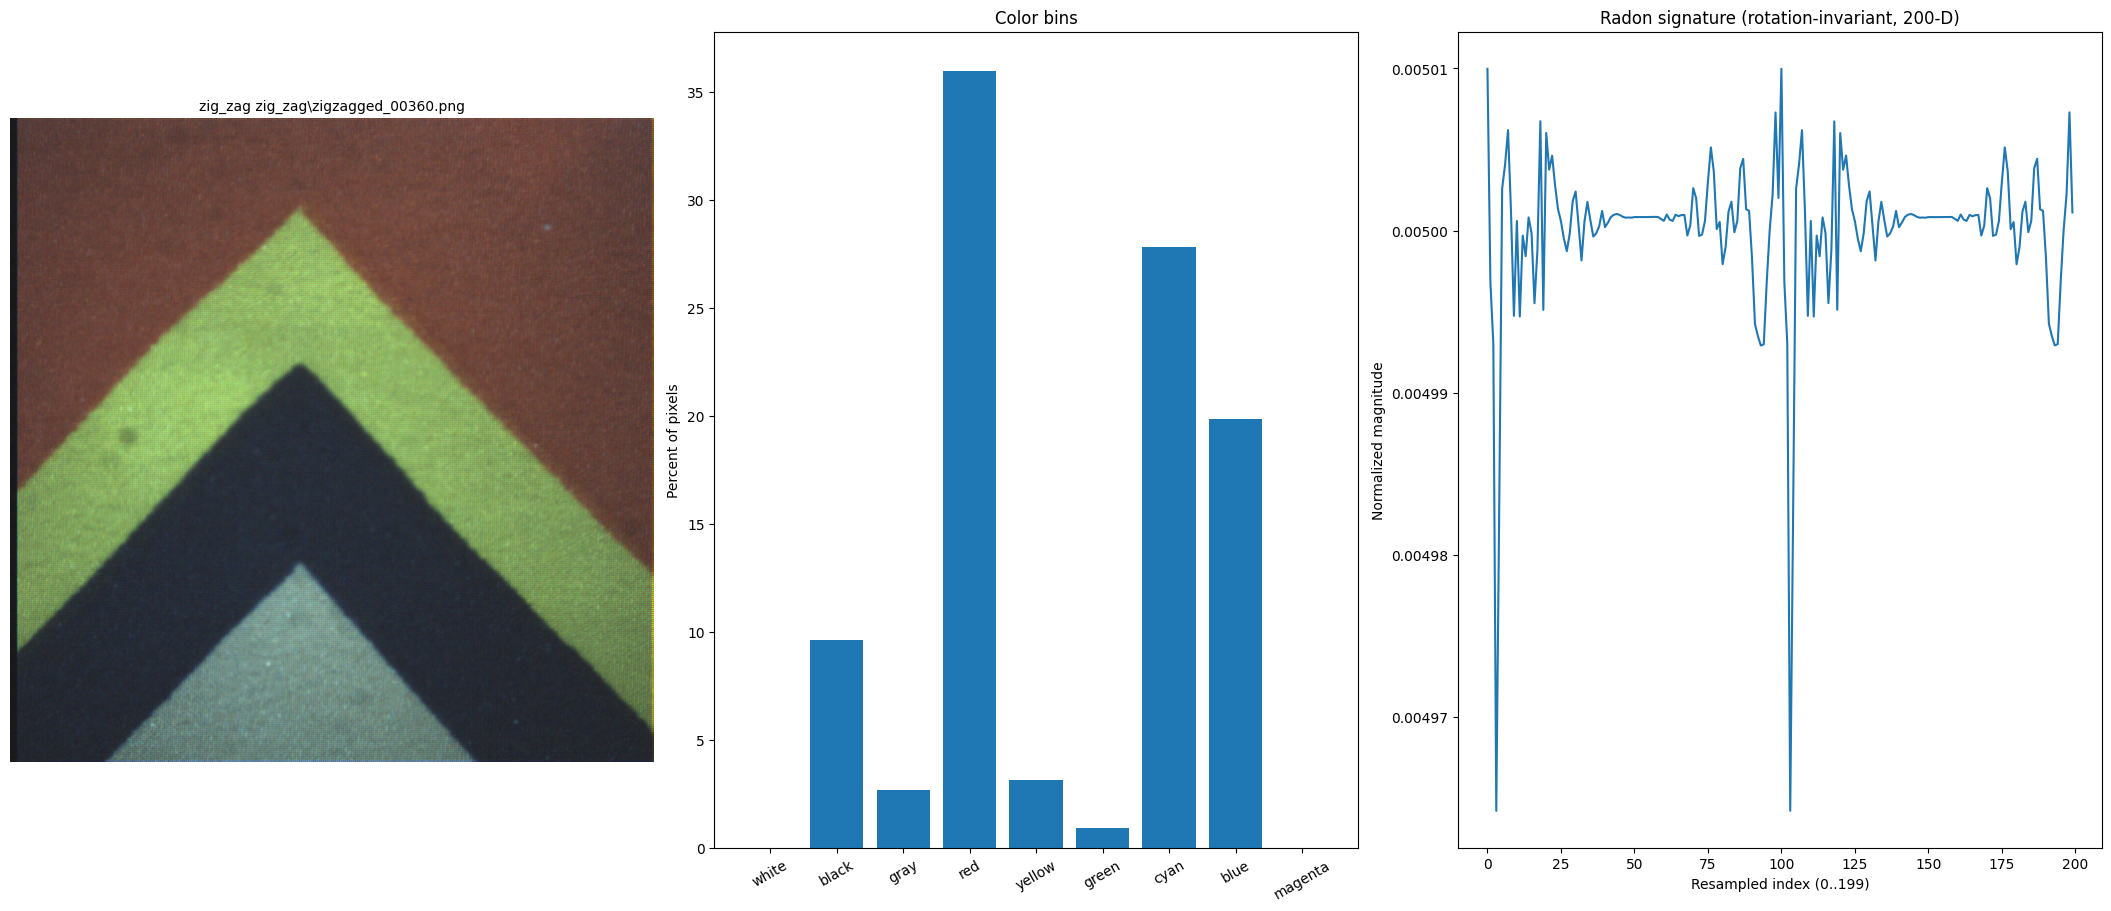

In [16]:
# pick random row to display

sample = df.sample(1).iloc[0]
img = Image.open(img_root / sample["file"]).convert("RGB")

radon_cols = [f"radon_{i:03d}" for i in range(200) if f"radon_{i:03d}" in sample.index]
radon_vec  = np.array([float(sample[c]) for c in radon_cols], dtype=float)

fig, axs = plt.subplots(1, 3, figsize=(21, 9), constrained_layout=True)

# show img
axs[0].imshow(img)
axs[0].set_axis_off()
axs[0].set_title(f"{sample['class']} {sample['file']}", fontsize=10)

# color percentages
axs[1].bar(COLOR_BINS, list(sample[f"color_{k}"] for k in COLOR_BINS))
axs[1].set_ylabel("Percent of pixels")
axs[1].set_title("Color bins")
axs[1].tick_params(axis='x', rotation=30)

axs[2].plot(radon_vec, linewidth=1.5)
axs[2].set_title("Radon signature (rotation-invariant, 200-D)")
axs[2].set_xlabel("Resampled index (0..199)")
axs[2].set_ylabel("Normalized magnitude")

plt.show()


Classification Report:
               precision    recall  f1-score   support

   checkered       0.53      0.50      0.52        34
      dotted       0.60      0.60      0.60        15
      floral       0.54      0.78      0.64        18
       solid       0.94      0.94      0.94        16
     striped       0.44      0.44      0.44        16
     zig_zag       0.87      0.62      0.72        21

    accuracy                           0.62       120
   macro avg       0.65      0.65      0.64       120
weighted avg       0.64      0.62      0.63       120



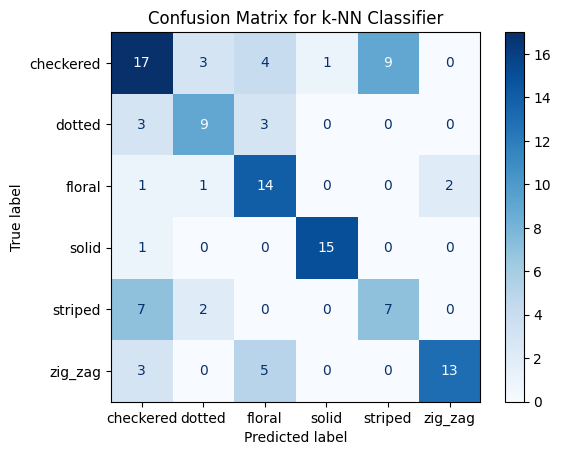

In [17]:
# SVC model

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Separate features (X) and labels (y)
feature_cols = [c for c in df.columns if c not in ['class', 'file']]
X = df[feature_cols]
y = df['class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune 'n_neighbors'
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for k-NN Classifier")
plt.show()

In [18]:
# AlexNet model. Torch setup
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Transformations for the training dataset (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations for the validation dataset (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
full_dataset = datasets.ImageFolder(root=img_root, transform=train_transforms)

In [19]:
# Define the sizes for the training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset randomly
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Overwrite the transform for the validation dataset
val_dataset.dataset.transform = val_transforms

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


Number of training images: 320
Number of validation images: 80


In [21]:
import torch.nn as nn
from torchvision import models

class_names = ["checkered", "dotted", "floral", "solid", "striped", "zig_zag"]

# Load a pre-trained AlexNet model
alexnet = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

# Freeze all layers in the feature extractor
for param in alexnet.features.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match your number of classes
num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))

# Print the modified model to confirm the change
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
import torch.optim as optim

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.001, momentum=0.9)

# Simple training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training Phase
    alexnet.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_dataset)

    # Validation Phase
    alexnet.eval() # Set the model to evaluation mode
    val_running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # No gradients needed for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_dataset)
    val_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10]
Training Loss: 1.2508, Validation Loss: 0.6070, Validation Accuracy: 82.50%
Epoch [2/10]
Training Loss: 0.3690, Validation Loss: 0.2688, Validation Accuracy: 86.25%
Epoch [3/10]
Training Loss: 0.2115, Validation Loss: 0.2715, Validation Accuracy: 86.25%
Epoch [4/10]
Training Loss: 0.1490, Validation Loss: 0.2102, Validation Accuracy: 91.25%
Epoch [5/10]
Training Loss: 0.1193, Validation Loss: 0.1817, Validation Accuracy: 90.00%
Epoch [6/10]
Training Loss: 0.0970, Validation Loss: 0.1714, Validation Accuracy: 93.75%
Epoch [7/10]
Training Loss: 0.0841, Validation Loss: 0.1618, Validation Accuracy: 93.75%
Epoch [8/10]
Training Loss: 0.0682, Validation Loss: 0.1673, Validation Accuracy: 92.50%
Epoch [9/10]
Training Loss: 0.0626, Validation Loss: 0.1602, Validation Accuracy: 93.75%
Epoch [10/10]
Training Loss: 0.0594, Validation Loss: 0.1398, Validation Accuracy: 93.75%


In [23]:
# Save the model
torch.save(alexnet.state_dict(), 'alexnet_pattern_model.pth')

# To load the model later:
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('alexnet_pattern_model.pth'))
model.eval() # Set model to evaluation mode

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 